### Importing packages

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import galsim
import time
import math
import numpy as np

### Reading and visualizing images

In [47]:
def read_header_and_data(file_path, idx):
    with fits.open(file_path) as hdu:  
        header = hdu[idx].header
        data = hdu[idx].data
        
        return header, data

def show_image(image_data, cmap='grey'):
    plt.figure()
    plt.imshow(image_data, cmap=cmap)
    plt.colorbar()

### Catalogue path

In [3]:
catalog_dir = '/home/hugobbi/ufrgs/etapa/fpi/trabalho-final/files-archive/COSMOS_23.5_training_sample/'
catalog_name = 'real_galaxy_catalog_23.5.fits'
catalog_path = catalog_dir + catalog_name

In [4]:
h_catalog, d_catalog = read_header_and_data(catalog_path, 1)

In [54]:
header, image = read_header_and_data(catalog_dir + 'real_galaxy_images_23.5_n1.fits', 23)

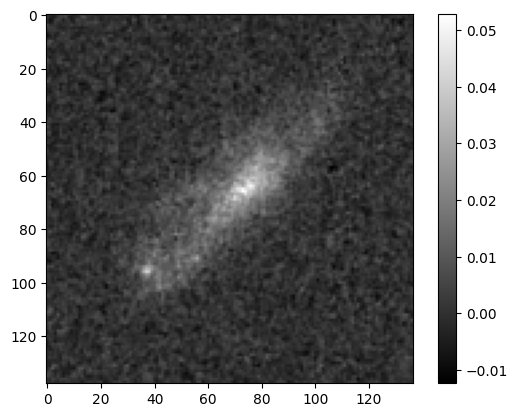

In [55]:
show_image(image)

### Simulating galaxy images with galsim

#### Auxiliary functions

In [48]:
def get_random_fwhm(initial_fwhms):
    fwhms = np.linspace(initial_fwhms[0], initial_fwhms[-1], 100)
    
    return np.random.choice(fwhms)

def compute_shear(shear_value, random_number):
    shear_beta = 2*math.pi * random_number * galsim.radians
    shear = galsim.Shear(g=shear_value, beta=shear_beta)

    return shear, shear_beta

def mean_subtract(img_data):
    img_mean = np.mean(img_data)
    img_data -= img_mean

    return img_data

In [8]:
rgc_cosmos = galsim.RealGalaxyCatalog(catalog_name, dir=catalog_dir)

#### Galsim and LSST parameters

In [22]:
# Galsim parameters
random_seed = galsim.BaseDeviate(11235813).raw()

# PSFs parameters
lens_shear_unifdist = np.random.uniform(0.01, 0.05) # from paper
atmos_shear_unifdist = np.random.uniform(0.01, 0.03) # from paper
fwhms = np.array([0.49, 0.62, 0.66, 0.78, 0.83]) # (Mandelbaum 2014)

# LSST parameters
pixel_scale = 0.2 # from paper
snrs = [100, 40, 20] # from paper
gain = 2.3 # electron/ADU (https://smtn-002.lsst.io/)
exp = 30 # s (https://smtn-002.lsst.io/)
zeropoint = 28 # AB (https://smtn-002.lsst.io/)
sky_brightness = 21.2 #  mag/arcsec^2 (https://smtn-002.lsst.io/)
total_readnoise = 8.8 # photo-electrons/pixel/exposure (https://smtn-002.lsst.io/)
qe = 0.95 # Quantum efficiency (estimated)
sky_level = 350 # ADU/pixel from paper
gaussian_noise_sd = 19.4 # ADU from paper

#### Generating images

(48, 48)
(48, 48)


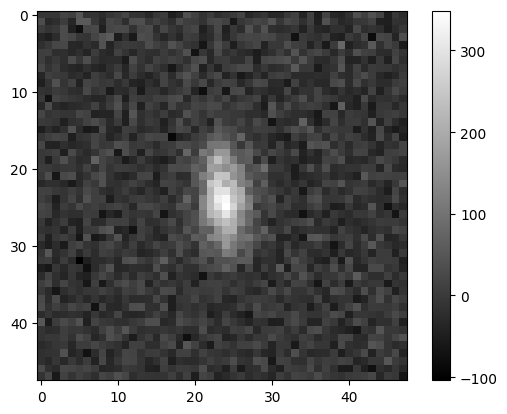

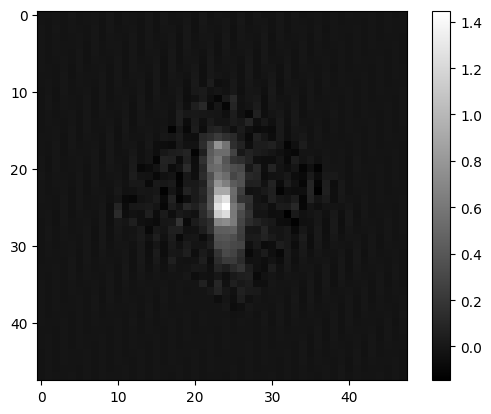

In [53]:
idx = 23
rng = galsim.UniformDeviate(random_seed) # Random number generator
original_galaxy = galsim.RealGalaxy(rgc_cosmos, index=idx)

# Random rotation
theta = 2*math.pi * rng() * galsim.radians
ground_truth_galaxy = original_galaxy.rotate(theta)

# Random shear
lens_shear, lens_shear_beta = compute_shear(lens_shear_unifdist, rng())
ground_truth_galaxy = ground_truth_galaxy.shear(g1=lens_shear.g1, g2=lens_shear.g2)

# Random lensing
#galaxy = galaxy.lens(g1=lens_shear.g1, g2=lens_shear.g2, mu=1.3)

# Magnify galaxy image
ground_truth_galaxy = ground_truth_galaxy.magnify(mu=1.082) # from demo6

# Generating ground truth galaxy
psf_hst = rgc_cosmos.getPSF(idx)
ground_truth_galaxy = galsim.Convolve([ground_truth_galaxy, psf_hst]) # Ground truth

# Atmospheric PSF
fwhm = get_random_fwhm(fwhms)
atmospheric_psf = galsim.Kolmogorov(fwhm=fwhm, flux=1)
# Adding random shear and rotation to atmospheric PSF
atmos_shear, atmos_shear_beta = compute_shear(atmos_shear_unifdist, rng())
atmospheric_psf = atmospheric_psf.shear(g1=atmos_shear.g1, g2=atmos_shear.g2)
atmos_theta = 2*math.pi * rng() * galsim.radians
atmospheric_psf = atmospheric_psf.rotate(atmos_theta)

# Optical PSF (adds aberrations according to uniform distribution)
optical_psf = galsim.OpticalPSF(lam=651, # (Mandelbaum 2014) 
                                diam=8.4, # LSST primary mirror diameter in m
                                flux=1,
                                defocus=0.36*rng(),
                                obscuration=0.07*rng(),
                                coma1=0.07*rng(),
                                coma2=0.07*rng(),
                                astig1=0.07*rng(),
                                astig2=0.07*rng())

# Convolving both PSFs to get final PSF
final_psf = galsim.Convolve([atmospheric_psf, optical_psf])

# Convolve ground truth galaxy with PSF to get lsst galaxy
lsst_galaxy = galsim.Convolve([ground_truth_galaxy, final_psf])

# Draw image of lsst galaxy
lsst_img = lsst_galaxy.drawImage(galsim.ImageF(48, 48), scale=pixel_scale, method='auto')

# Adding noise
snr = snrs[0]

# CCD noise
ccd_noise = galsim.CCDNoise(rng, sky_level=sky_level, gain=gain, read_noise=total_readnoise)

# Gaussian noise
gauss_noise = galsim.GaussianNoise(rng, gaussian_noise_sd)

# Applying noise considering specific snr
lsst_img.addNoiseSNR(noise=ccd_noise, snr=snr, preserve_flux=False)
lsst_img.addNoiseSNR(noise=gauss_noise, snr=snr, preserve_flux=False)

# Creating ground truth image
ground_truth_img = ground_truth_galaxy.drawImage(galsim.ImageF(48, 48), scale=pixel_scale, method='auto')

# Visualizing LSST image
show_image(mean_subtract(lsst_img.array))
print(lsst_img.array.shape)

# Visualizing ground truth image
show_image(mean_subtract(ground_truth_img.array))
print(ground_truth_img.array.shape)

# Write image to file
galsim.fits.write(lsst_img, 'final.fits')

### Reading images

#### Visualizing images

(48, 48)
48


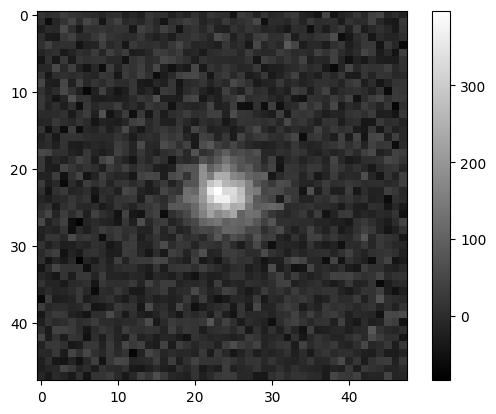

In [38]:
ihead, idata = read_header_and_data('final.fits', 0)
show_image(idata)
print(idata.shape)

print(idata.shape[1])

#### Visualizing demo6 images

In [ ]:
ihead, idata = read_header_and_data('output/cube_real.fits', 0)
show_image(idata[0])